In [ ]:
pip install Bio

In [1]:
import numpy as np
import pandas as pd
from io import StringIO
from Bio import Phylo

In [2]:
# pairwise_sequence_alignment
def pairwise_sequence_alignment(seq_1,seq_2):
    count_missmatch = 0
    for i in range(len(seq_1)):
        if seq_1[i] != seq_2[i]:
            count_missmatch += 1
    return count_missmatch

In [3]:
# mismatche_matrix function 
def  mismatche_matrix(seq_list, seq_names):
    n = len(seq_list)
    mismatch_m = np.zeros((n,n))

    for i in range(n):
        sub_seq_list = seq_list[i+1:]
        for j in range(len(sub_seq_list)):
            matrix_j = j+i+1
            pairwise_seq = pairwise_sequence_alignment(seq_list[i],sub_seq_list[j])
            mismatch_m[i][matrix_j] = mismatch_m[matrix_j][i] = pairwise_seq

    mismatch_matrix_df = pd.DataFrame(data=mismatch_m, columns=seq_names ,index=seq_names)
    
    return mismatch_matrix_df

In [4]:
# This function return Minimum value greater than 0 in a dataframe
def min_val_index_df(df): 
    # Finding the minimum value greater than 0
    min_val = df[df > 0].min().min()
    # Getting the indices of the minimum value
    indices = df[df == min_val].stack().index.tolist()

    return min_val, list(indices[-1])

In [5]:
def cal_cluster_distance(df,df_copy,new_cluster_name):
    cluster_missmatch_socre = []
    for col in df_copy.columns:
        distance = 0
        # caclulate distance between 
        for sub_cluster in col:
            for pairs in new_cluster_name:
                distance += df[sub_cluster][pairs]
        distance = distance / (len(col)*len(new_cluster_name))
        #print("Distance between",col,new_cluster_name,"is",distance)
        cluster_missmatch_socre.append(distance)
    return cluster_missmatch_socre

In [6]:
def construct_tree(df):
    dict_tree_newick_format = {} 
    df_copy = df.copy()
    while len(df_copy) > 1 :
        min_val, min_indices = min_val_index_df(df_copy)
        #print(min_val, min_indices )

        # Create new cluster  for pairs (i,j)
        ## intialize the new cluster name u 
        new_cluster_name = min_indices[0]+min_indices[1]
        ## calculate the distance between u_i and u_z
        cluster_branch_distance = min_val/2
        ## update the tree_newick_format 
        i = str(min_indices[0])
        j = min_indices[1]

        cluster_branch_distance_i = cluster_branch_distance_j = cluster_branch_distance

        
        if len(min_indices[0]) > 1:
            i = dict_tree_newick_format[min_indices[0]][1]
            #print("A",dict_tree_newick_format[min_indices[0]][1],"B", dict_tree_newick_format[min_indices[0]][0])
            cluster_branch_distance_i = cluster_branch_distance - dict_tree_newick_format[min_indices[0]][0]/2
        if len(min_indices[1]) > 1:
            j = dict_tree_newick_format[min_indices[1]][1]
            cluster_branch_distance_j = cluster_branch_distance - dict_tree_newick_format[min_indices[1]][0]/2

        tree_newick_format = "("+i+":"+str(cluster_branch_distance_i)+","+j+":"+str(cluster_branch_distance_j)+")"
        dict_tree_newick_format[new_cluster_name] = [min_val,tree_newick_format]
        #print(tree_newick_format)
        #print(dict_tree_newick_format)

        # Upadte the mismatch matrix
        ## Delete pairs i j from the df 
        df_copy.drop(min_indices, axis=1, inplace=True)
        df_copy.drop(min_indices, axis=0, inplace=True)

        ## Compute the distance between the new cluster and the others 
        cluster_missmatch_socre = cal_cluster_distance(df,df_copy,new_cluster_name)
        #print(cluster_missmatch_socre)

        # Upadte the mismatch matrix
        ## create new col with new cluster name and a new row 
        ### add col
        df_copy[new_cluster_name] = cluster_missmatch_socre
        ### add row 
        cluster_missmatch_socre.append(0)
        df_copy.loc[new_cluster_name] = cluster_missmatch_socre
        #print(df_copy)

        #print("+++++++++++++++++++++++++++++++++++++++++++")
    return list(dict_tree_newick_format.items())[-1][1][1]

In [7]:
def upgma_algorithm(seq_list,seq_names):
    df = mismatche_matrix(seq_list,seq_names)
    return construct_tree(df)

---

In [8]:
# Sequences 
a = "ATCGATCG"
b = "GTAGACGA"
c = "ACCGTACG"
d = "TCAGTCAG"
e = "GCCTACAG"

seq_list = [a,b,c,d,e]
seq_names = ['A','B','C','D','E']
tree_newick_format = upgma_algorithm(seq_list,seq_names)
print(tree_newick_format)

(((E:2.0,D:2.0):0.5,(C:1.5,A:1.5):1.0):0.25,B:2.75)


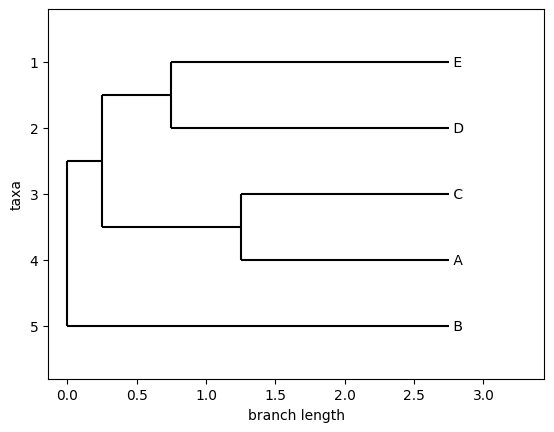

In [12]:
# Read the tree from the Newick format string
tree = Phylo.read(StringIO(tree_newick_format), "newick")

# Plot the tree
Phylo.draw(tree)